In [1]:
import numpy as np

Some color constants

In [2]:
BLUE = "#1f77b4"
GREEN = "#2ca02c"
ORANGE = '#ff7f0e'
RED = '#d62728'

Consider the arbitrage situation for one pair (for example, eth vs usd) on two exchanges A and B:

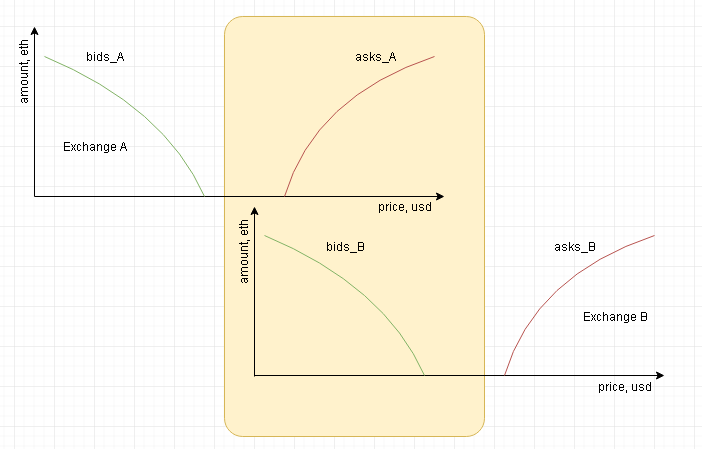


We are now interested in the asks_A and bids_B in the yellow rectangle, let's just call them asks and bids:

In [3]:
bids = np.array([(67, 2), (63, 1), (61, 4), (56, 1), (50, 1), (45, 2)])
asks = np.array([(50, 3), (52, 1), (58, 1), (59, 3), (60, 1), (70, 2)])

In [4]:
for b, a in zip(bids, asks):
    print(b[0], b[1], a[0], a[1])

67 2 50 3
63 1 52 1
61 4 58 1
56 1 59 3
50 1 60 1
45 2 70 2


Let's plot them:

In [5]:
from matplotlib import pyplot as plt

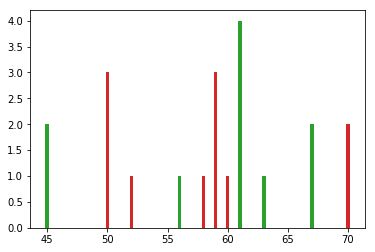

In [6]:
plt.bar(bids[:,0], bids[:,1], width=0.3, color=GREEN);
plt.bar(asks[:,0], asks[:,1], width=0.3, color=RED);

To get a better idea of what's going on, usually people use integrals:

In [7]:
bids_cumsum = np.cumsum(bids[:,1])
asks_cumsum = np.cumsum(asks[:,1])

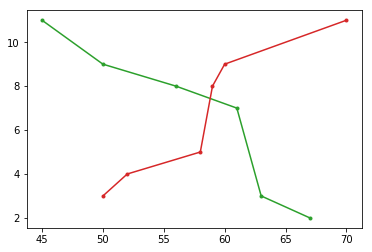

In [8]:
plt.plot(bids[:,0], bids_cumsum, '.-', color=GREEN)
plt.plot(asks[:,0], asks_cumsum, '.-', color=RED)

The lines plot might be misleading, a better way to plot this is bar-plot. First let's calculate the widths of the bars:

In [9]:
(asks[:,0])

array([50, 52, 58, 59, 60, 70])

In [10]:
(asks_cumsum)

array([ 3,  4,  5,  8,  9, 11], dtype=int32)

Now the bar plot:

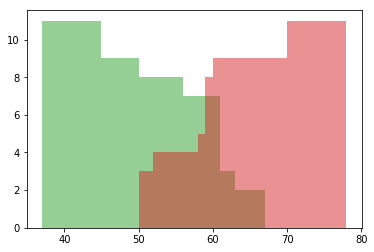

In [11]:
plt.bar(bids[:,0], bids_cumsum, width=np.append(bids[1:,0]-bids[:-1,0], -8), align='edge', color=GREEN, alpha=0.5);
plt.bar(asks[:,0], asks_cumsum, width=np.append(asks[1:,0]-asks[:-1,0], 8), align='edge', color=RED, alpha=0.5);

**Todo:**  
    0) consider 0% exchange commission;  
    1) calculate max amount of usd the can be earned according to this snapshot;  
    2) plot of expected profit (in percents) against invested funds;  
    3) plot of expected profit (absolute value in usd) against invested funds;  
    4) calculate the limit orders parameters:  
&nbsp;      a) amount of eth to buy on exchange A, limit price on exchange A;  
&nbsp;      b) amount of eth to sell on exchange B, limit price on exchange B;  
    5) repeat steps 1-4 with 0.2% exchange commission on both exchanges.

In [26]:
from collections import deque
import decimal
from decimal import Decimal as D

f2D = np.vectorize(lambda x: D(str(x)))

def f8(x):
    # округляет вниз до 8 знака
    return x.quantize(D('0.00000001'), rounding=decimal.ROUND_DOWN)

def init_deque(np_amount, np_price):
    res = deque()
    for el in zip(np_amount, np_price):
        res.append(el)
    return res


def calc(d_bids, d_asks, fee = 0):
    profit, investments = 0, 0
    eth_buy, eth_sell = 0, 0
    limit_buy, limit_sell = 0, 0
    profPer_invest, profAbs_invest = np.empty((1, 2)), np.empty((1, 2))
    if( d_bids and d_asks):
        bid, ask = d_bids.popleft(), d_asks.popleft()
        while(1):
            ask, bid = (f8(f2D(ask[0]) * f2D(1 + fee)), ask[1]), (f8(f2D(bid[0]) * f2D(1 - fee)), bid[1]) #для учета комиссии биржи
            if ask[0] >= bid[0]:#выход, если цена продажи < цены покупки
                break
            
            limit_buy, limit_sell = ask[0], bid[0]
            #выбираем то, где меньше amount, т.е. min(bid[1], ask[1])
            if bid[1] > ask[1]: #случай для min = ask[1] 
                count = ask[1] #значит оперируем именно таким количеством
                profit += count * (bid[0] - ask[0])#получается такая прибыль

                investments += ask[0] * count #и такие расходы
                profPer_invest = np.vstack((profPer_invest, [profit / investments * 100 ,investments ]))
                profAbs_invest = np.vstack((profAbs_invest, [profit, investments]))
                if not d_asks: #выход, если в очереди больше нет пары
                    break
                bid = (bid[0], bid[1] - count)
                if(bid[1] == 0):#если amount вдруг стал равным 0, то либо подгрумаем следющую пару, либо выход
                    if d_bids:
                        bid = d_bids.popleft()
                    else:
                        break

                ask = d_asks.popleft()
            else:#случай для min = bid[1]
                count = bid[1]
                profit += count * (bid[0] - ask[0])

                investments += ask[0] * count
                profPer_invest = np.vstack((profPer_invest, [profit / investments * 100 ,investments ]))
                profAbs_invest = np.vstack((profAbs_invest, [profit, investments]))
                if not d_bids:
                    break
                ask = (ask[0], ask[1] - count)

                if(ask[1] == 0):
                    if d_asks:
                        ask = d_asks.popleft()
                    else:
                        break
                bid = d_bids.popleft() 
            
    print("Amount of usd that can be earned is",profit)
    print("Limit price of eth to buy is",limit_buy)
    print("Limit price of eth to sell is",limit_sell)
    plt.figure(1)
    plt.plot(profPer_invest[1:, 1], profPer_invest[1:, 0],  '.-', color=RED)#вывод графика дохода в процентах относ. инвестиций
    plt.figure(2)
    plt.plot(profAbs_invest[1:, 1], profAbs_invest[1:, 0],  '.-', color=BLUE)#вывод графика дохода в абс. велич. относ. инвестиций
    
        

Amount of usd that can be earned is 102.00000000
Limit price of eth to buy is 58.00000000
Limit price of eth to sell is 61.00000000


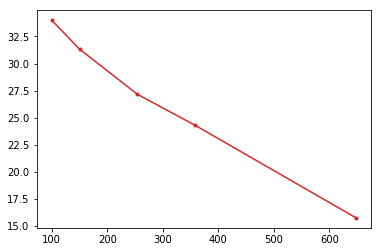

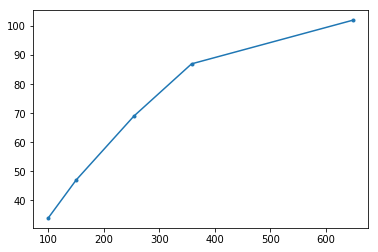

In [27]:
d_bids, d_asks = init_deque(bids[:,0], bids_cumsum), init_deque(asks[:,0], asks_cumsum)
calc(d_bids, d_asks)

Amount of usd that can be earned is 98.03510800
Limit price of eth to buy is 58.11600000
Limit price of eth to sell is 60.75624400


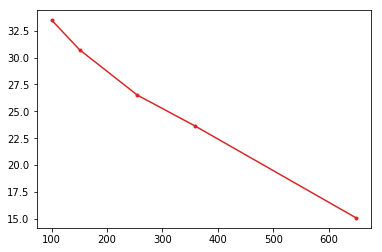

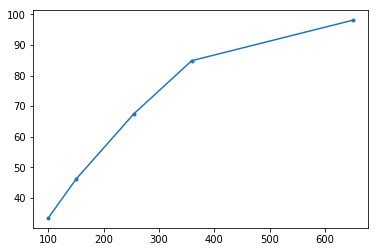

In [28]:
d_bids, d_asks = init_deque(bids[:,0], bids_cumsum), init_deque(asks[:,0], asks_cumsum)
calc(d_bids, d_asks, 0.002)